# Ridge-Lasso Regression

> In this post, We will review the way of generalization, especially on Ridge and Lasso.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Machine_Learning]
- image: images/ridge_reg.png

## Packages

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path, Lasso, Ridge
np.random.seed(1)

## Ridge Penalty

In logistic Regression, we can define the loss function like this,

$$ L(\beta; \lambda) = -\frac{1}{n} \sum_{i=1}^n (y_i x_i^T \beta - \log(1+ \exp(x_i^T \beta))) $$

For the Regularization, we can add the penalty term. In this case, we added Ridge penalty (also known as L2 error). That is, we measure the squared beta for the penalty.

$$ L(\beta; \lambda) = -\frac{1}{n} \sum_{i=1}^n (y_i x_i^T \beta - \log(1+ \exp(x_i^T \beta))) + \lambda \Vert \beta \Vert_2^2 $$

In [2]:
p = 2
lambda_v = 1.5
n = 10
true_beta = np.array([[1], [-0.5]])

So we need to make predictor. In this example, we assume that the sample data is from binomial distribution.

In [3]:
x = np.random.normal(0, 1, (n, p))
prob = 1 / (1 + np.exp(-x @ true_beta))
prob = prob.reshape((n,))
prob

array([0.87327416, 0.50207813, 0.88248512, 0.89334897, 0.60914609,
       0.92359167, 0.4674486 , 0.84339584, 0.56623371, 0.43802193])

In [5]:
y = np.random.binomial(np.ones(n, dtype='int32'), prob, n)
y = y.reshape((n, 1))
y

array([[1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0]])

Currently, we generate the ture data from true beta. So how can we get true beta from initial beta?

In [6]:
beta = np.array([.5, .5]).reshape((p, 1))
prob = 1 / (1 + np.exp(-x @ beta))
prob

array([[0.62393741],
       [0.30990356],
       [0.32781911],
       [0.62053095],
       [0.50870771],
       [0.42579795],
       [0.41259797],
       [0.50423467],
       [0.37165034],
       [0.5774989 ]])

With Newton raphson method, we differentiate it two times.

$$ g = \frac{\partial}{\partial\beta} L(\beta; \lambda) = -\frac{1}{n} \sum_{i=1}^n \big( y_i x_i - \frac{\exp(x_i^T \beta)}{1 + \exp(x_i^T \beta)} x_i \big) + 2 \lambda \beta \\
 H = \frac{\partial^2}{\partial \beta^2} L(\beta ; \lambda) = \frac{1}{n} \sum_{i=1}^n \big( \frac{\exp(x_i^T \beta)}{1 + \exp(x_i^T \beta)} \cdot \frac{1}{1 + \exp(x_i^T \beta)} \big) x_i x_i^T + 2 \lambda I$$

In [7]:
grad = np.mean((prob - y) * x, axis=0, keepdims=True).T + 2 * lambda_v * beta
grad

array([[1.28165535],
       [1.80853325]])

In [8]:
D = np.diag((prob * (1 - prob)).reshape(n))
D[:5, :5]

array([[0.23463952, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.21386334, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.22035374, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.23547229, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.24992418]])

In [9]:
H = x.T @ D @ x / n + np.diag(np.repeat(2 * lambda_v, p))
H

array([[ 3.24626658, -0.18603102],
       [-0.18603102,  3.32919247]])

After we calculate the gradient and hessian matrix of one optimization, we do the one step for the beta update. All we need to do is to repeat these steps until the threshold is reached.

In [11]:
beta = np.zeros((p, 1))
beta_0 = []
beta_1 = []

for i in range(10):
    prob = 1 / (1 + np.exp(-x @ beta))
    grad = np.mean((prob - y) * x, axis=0, keepdims=True).T + 2 * lambda_v * beta
    D = np.diag((prob * (1 - prob)).reshape(n))
    H = x.T @ D @ x / n + np.diag(np.repeat(2 * lambda_v, p))
    
    beta_new = beta - np.linalg.inv(H) @ grad
    beta_0.append(beta_new[0])
    beta_1.append(beta_new[1])
    
    if np.sum(np.abs(beta_new - beta)) < 1e-8:
        beta = beta_new
        print('Iteration {} beta:'.format(i))
        print(beta, '\n')
        break
    else:
        beta = beta_new
        print('Iteration {} beta:'.format(i))
        print(beta, '\n')    

Iteration 0 beta:
[[ 0.07280789]
 [-0.0647952 ]] 

Iteration 1 beta:
[[ 0.07283667]
 [-0.06483139]] 

Iteration 2 beta:
[[ 0.07283667]
 [-0.06483139]] 



We almost found the solution for beta. So does this solution satisfy the optimality? Or Is the gradient of 0 at this beta? One way to check this is to apply [Karush-Kuhn-Tucker (KKT) condition](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions).

In [12]:
prob = 1 / (1 + np.exp(-x @ beta))
grad = np.mean((prob - y) * x, axis=0, keepdims=True).T + 2 * lambda_v * beta
grad

array([[2.77555756e-17],
       [0.00000000e+00]])

In [13]:
np.all(np.abs(grad) < 1e-8)

True

In this time, we will use Lasso and Ridge Regression implemented in scikit-learn. 

At first, we need to find solution path for each lambda.

Note that, Ridge penalty can be expressed like this,

$$ \beta(\lambda) = \arg\min_{\beta} \frac{1}{2} \Vert Y - X \beta \Vert^2 + \lambda \Vert \beta \Vert^2 $$

In [25]:
n_lambdas = 50
lambda_vec = np.linspace(0, 100, n_lambdas)

In [30]:
coefs = []
for lambda_v in lambda_vec:
    ridge = Ridge(alpha=lambda_v, fit_intercept=False)
    ridge.fit(x, y)
    coefs.append(ridge.coef_)
coefs = np.squeeze(np.array(coefs))
coefs[:6, :]

array([[ 0.30933704, -0.3050756 ],
       [ 0.27101754, -0.28508068],
       [ 0.2436212 , -0.26489766],
       [ 0.22216416, -0.24649493],
       [ 0.2045881 , -0.23010196],
       [ 0.18979669, -0.21556417]])

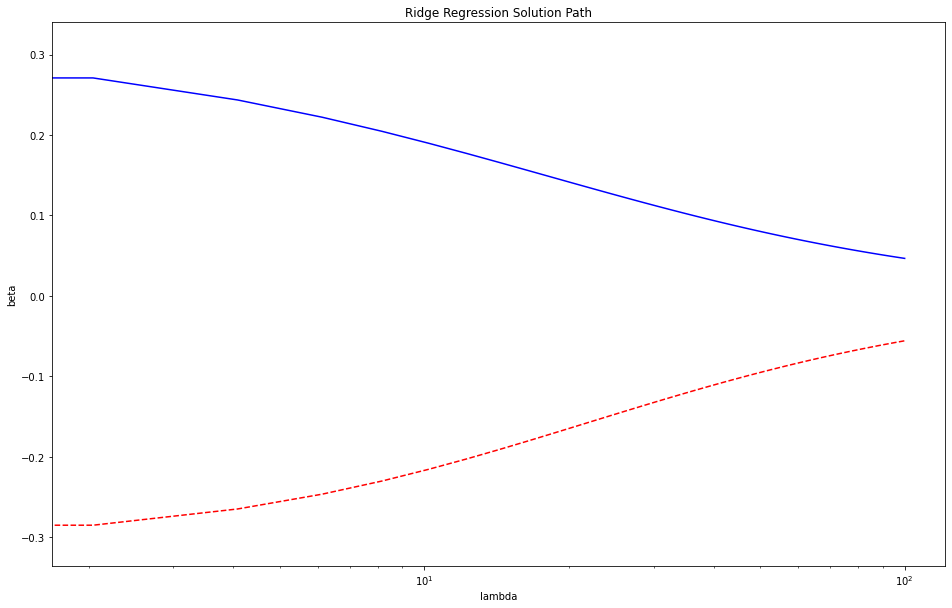

In [35]:
plt.figure(figsize=(16, 10))
colors = ['b', 'r', 'g']
lstyles = ['-', '--', '-.', ':']

for i in range(p):
    l = plt.plot(lambda_vec, coefs[:, i], linestyle=lstyles[i], c=colors[i])
plt.xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('beta')
plt.title('Ridge Regression Solution Path')
plt.show()

As you can see, when the $\lambda$ is increased, $\beta$ is closed to 0, which means the **'shrinkage'** of the beta.

Unlike Ridge, Lasso uses absolute beta for the penalty.

$$ \beta(\lambda) = \arg\min_{\beta} \frac{1}{2} \Vert Y - X \beta \Vert^2 + \lambda \vert \beta \vert $$

In [36]:
eps = 5e-3

lambdas_lasso, coefs_lasso, _ = lasso_path(x, y, eps=eps, fit_intercept=False)
coefs_lasso = np.squeeze(coefs_lasso)
coefs_lasso[:, :5]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-5.27325648e-17, -2.47515217e-02, -4.82132055e-02,
        -7.04522666e-02, -9.15324179e-02]])

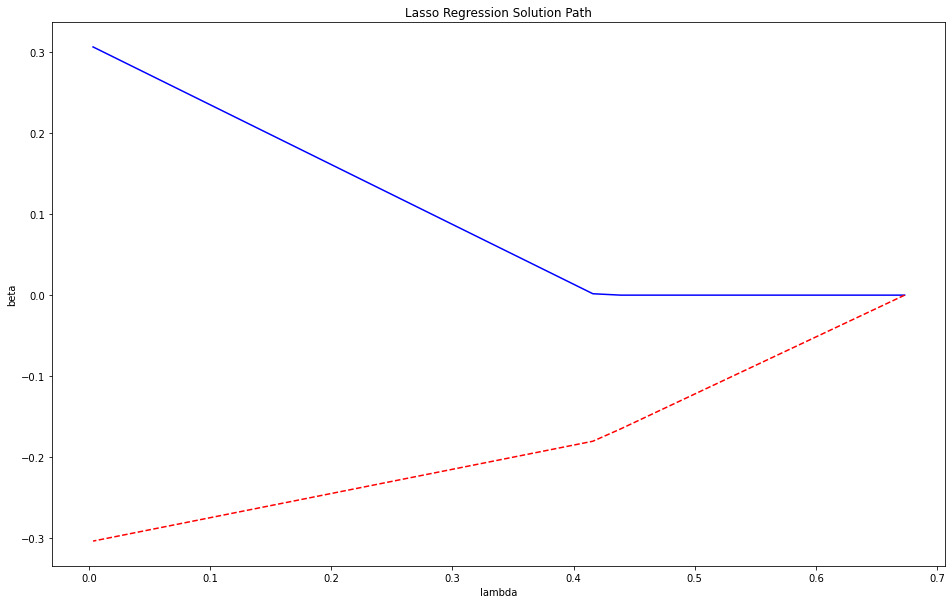

In [37]:
plt.figure(figsize=(16, 10))
colors = ['b', 'r', 'g']
lstyles = ['-', '--', '-.', ':']

for coef, c, l in zip(coefs_lasso, colors, lstyles):
    l = plt.plot(lambdas_lasso, coef, linestyle=l, c=c)
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('beta')
plt.title('Lasso Regression Solution Path')
plt.show()